In [1]:
from random import randint
import numpy as np
import matplotlib.pyplot as plt

# from util import return_normal
# from plicies import e_greedy

In [2]:
class Policy(object):
    """
    A policy prescribes an action to be taken based on the memory of an agent.
    """
    def __str__(self):
        return 'generic policy'

    def choose(self, agent):
        return 0


class EpsilonGreedyPolicy(Policy):
    """
    The Epsilon-Greedy policy will choose a random action with probability
    epsilon and take the best apparent approach with probability 1-epsilon. If
    multiple actions are tied for best choice, then a random action from that
    subset is selected.
    """
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def __str__(self):
        return '\u03B5-greedy (\u03B5={})'.format(self.epsilon)

    def choose(self, value_estimates):
        if np.random.random() < self.epsilon:
            return np.random.choice(len(value_estimates))
        else:
            action = np.argmax(value_estimates)
            check = np.where(value_estimates == action)[0]
            if len(check) == 0:
                return action
            else:
                return np.random.choice(check)

In [3]:
class MultiArmedBandit(object):
    """
    A Multi-armed Bandit
    """
    def __init__(self, k):
        self.k = k
        self.action_values = np.zeros(k)
        self.optimal = 0

    def reset(self):
        self.action_values = np.zeros(self.k)
        self.optimal = 0

    def pull(self, action):
        return 0, True


class GaussianBandit(MultiArmedBandit):
    """
    Gaussian bandits model the reward of a given arm as normal distribution with
    provided mean and standard deviation.
    """
    def __init__(self, k, mu=0, sigma=1):
        super(GaussianBandit, self).__init__(k)
        self.mu = mu
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.action_values = np.random.normal(self.mu, self.sigma, self.k)
        self.optimal = np.argmax(self.action_values)

    def pull(self, action):
        return (np.random.normal(self.action_values[action]),
                action == self.optimal)

In [4]:
# parâmetros de execução
K = 3 # braços
T = 1000 # nr de iterações

n = 3 # nr de iterações para montar a estimativa inicial das médias

In [5]:
# médias e variâncias dos braços
arm_means = [1.3, 2.27, 2.7]
arm_variances = [0.01, 0.1, 1]

# baseado numa distribução normal, obtem-se as recompensas em cada braço
rewards = [list(np.random.normal(size=T+n, loc=arm_means[i], scale=arm_variances[i])) for i in range(K)]

# use os primeiros valores para calcular a estimativa inicial das médias para cada braço
means_k = []
for i in range(K):
    # média dos n primeiros valores para cada braço
    means_k.append(np.mean(rewards[i][:n]))
    # remove as n recompensas utilizadas inicialmente
    rewards[i] = rewards[i][n:]

(array([  2.,  12.,  54., 134., 247., 277., 187.,  70.,  15.,   2.]),
 array([-1.10909191, -0.37708662,  0.35491868,  1.08692398,  1.81892927,
         2.55093457,  3.28293987,  4.01494516,  4.74695046,  5.47895575,
         6.21096105]),
 <a list of 10 Patch objects>)

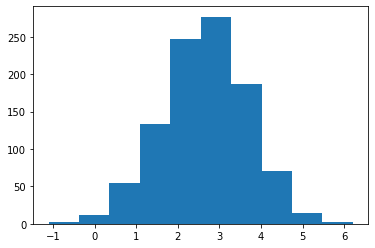

In [13]:
plt.hist(np.random.normal(loc=2.7, scale=1, size=1000))

In [6]:
# mostra a média real do melhor braço: que sabemos ser o 2
best_arm = rewards.index(max(rewards))
real_avg = np.mean(rewards[best_arm])
print(f"média do braço {best_arm}: {np.round(real_avg, 5)}")

média do braço 2: 2.76551


In [14]:
means_k

[1.297342250707753, 2.257993192481261, 2.7800707680059245]

In [7]:
# simple MAB algorithm
def run(K, T, rewards, method, verbose=False, **kwargs):
    """
    return: selected_arm (lista com os braços selecionados a cada instante)
    return: r (recompensa obtida para cada seleção)
    """
    num_selected_arm = [1 for i in range(K)]
    r = [-1 for i in range(T)]
    method.select_arm = []
    method.r = []
    for i in range(T):
        arm = method.choose(means_k)
        
        r_t = rewards[arm][i]
        r[i] = r_t
        
        # update mean
        means_k[arm] = num_selected_arm[arm] * means_k[arm] + r_t
        num_selected_arm[arm] += 1
        means_k[arm] /= num_selected_arm[arm]
        if verbose:
            print("round", i, "best_arm", arm, "reward", r_t)
        method.select_arm.append(arm)
        method.r.append(r_t)
    
    return method.select_arm, r

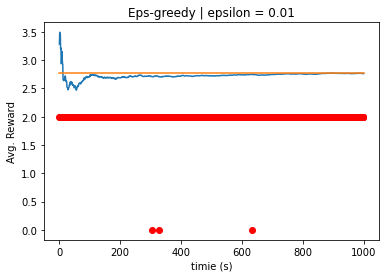

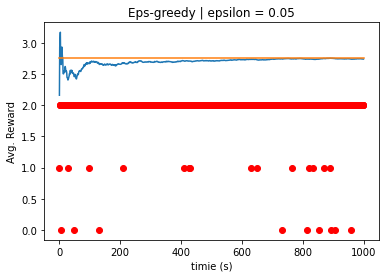

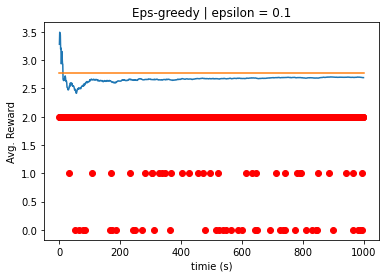

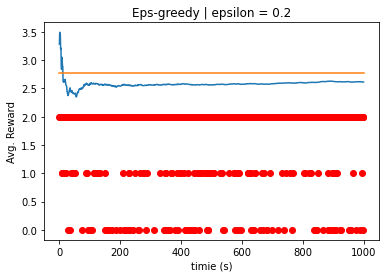

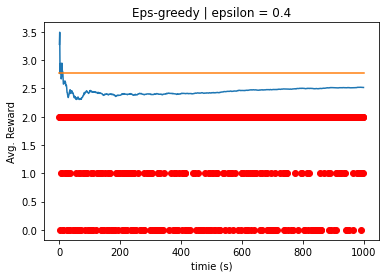

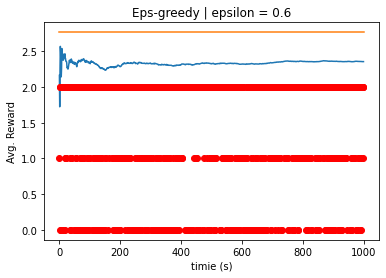

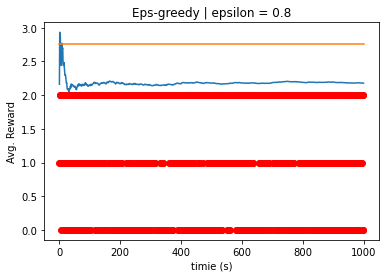

In [8]:
fig = 1
for epsilon in [0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8]:
    selected_arm, r = run(K, T,
                          method=EpsilonGreedyPolicy(epsilon=epsilon),
                          rewards=rewards,
                          means_k=means_k)
    r_mean = [np.mean(r[:i + 1]) for i in range(T)]
    plt.figure(fig)
    X = [i for i in range(T)]
    plt.plot(X, r_mean, X, selected_arm, 'ro')
    plt.plot([0, T], [real_avg, real_avg])
    plt.ylabel("Avg. Reward")
    plt.xlabel("timie (s)")
    y_max = 0.9 * max(r_mean)
    plt.title(f"Eps-greedy | epsilon = {np.round(epsilon, 2)}")
    fig += 1